En cuadernos anteriores se encontró con el problema de que algunos sensores se quedaban trabados y mostraban la misma lectura durante horas. Este cuaderno arreglará este problema.

Autor: Duo

In [265]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error

In [266]:
df = pd.read_csv("/home/duo/Projects/proyecto-computacion-I/data/datasets/Metricas_limpias.csv")

In [267]:
df.columns

Index(['timestamp', 'value', 'sensor_id', 'metric', 'unit', 'batch',
       'trans_value', 'z_score_abs'],
      dtype='object')

In [268]:
df.metric.unique()

array(['PH', 'AMONIO', 'CLOROFILA', 'CARBONO ORGANICO',
       'OXIGENO DISUELTO', 'CONDUCTIVIDAD', 'TURBIDEZ', 'TEMPERATURA',
       'FICOCIANINAS', 'NIVEL', 'FOSFATOS', 'NITRATOS'], dtype=object)

Esta función está explicada en otro cuaderno

In [269]:
def pintar_graficas(df_input):
    # Evitar modificar el dataframe original fuera de la función
    df = df_input.copy()

    if df.empty:
        print("El DataFrame pasado está vacío.")
        return

    df['timestamp'] = pd.to_datetime(df['timestamp'])

    sns.set_theme(style="whitegrid", palette="muted")
    metrics = df['metric'].unique()

    for metric in metrics:
        subset = df[df['metric'] == metric]

        if len(subset) < 10:
            print(f"Métrica '{metric}' ignorada: muy pocos datos ({len(subset)}).")
            continue

        plt.figure(figsize=(10, 6))

        sns.lineplot(data=subset, x="timestamp", y="value", hue="sensor_id", marker='o')

        plt.title(f"Métrica: {metric}")
        plt.xlabel("Fecha")
        plt.ylabel("Valor")
        plt.xticks(rotation=45)

        if metric == 'TEMPERATURA':
            media = subset['value'].mean()

            # Definimos los límites: 2.5 abajo y 2.5 arriba de la media
            # Esto fuerza que la altura total del gráfico sea siempre de 5 grados
            plt.ylim(media - 2.5, media + 2.5)

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

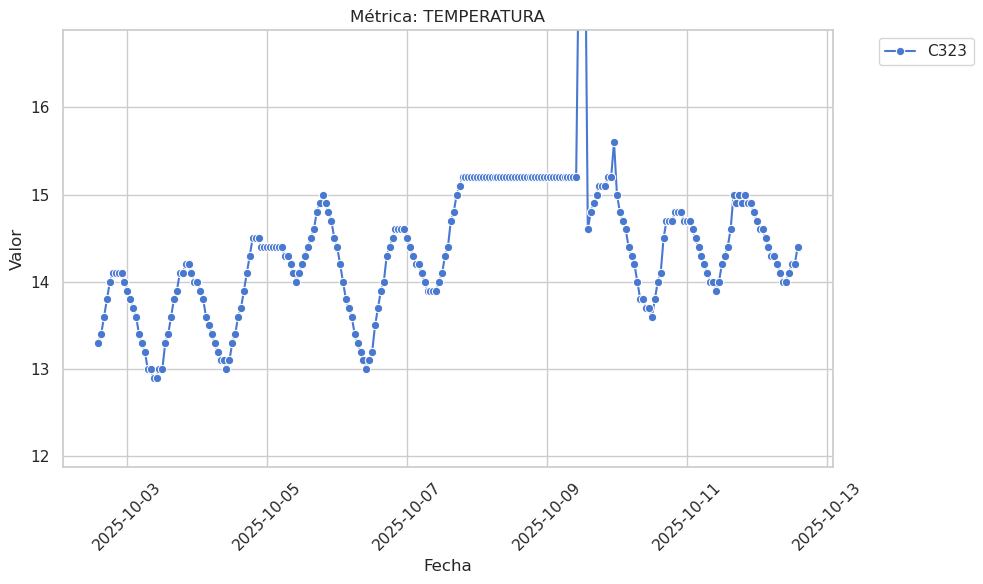

In [270]:
pintar_graficas(df[(df['batch'] == 'batch1') & (df['sensor_id'] == 'C323') & (df['metric'] == 'TEMPERATURA')])

Este es el problema que se quiere abordar. Solo vamos a abordar las variables de ciclo diario ya que para una demostración académica es más que suficiente.
Estas son las variables que vamos a tratar:

TEMPERATURA: El ciclo día/noche es ineludible. Además, la inercia térmica impide cambios instantáneos, pero también impide la estabilidad absoluta perfecta (siempre hay decimales variando).

OXIGENO DISUELTO (OD): Es la respiración del agua. Sube de día (fotosíntesis) y baja de noche (respiración). Si el OD está plano, la membrana del sensor está sucia o el sensor se ha colgado.

PH: Aunque es más estable, en un río el pH fluctúa con el OD debido al ciclo del CO2/Carbonatos. Un pH clavado en 7.00 o 8.15 durante 6 horas es sospechoso, a menos que sea un agua extremadamente tamponada (poco probable en río abierto).

CLOROFILA / FICOCIANINAS: Son pigmentos de algas. Se mueven con la luz y las corrientes. Valores estáticos aquí suelen indicar que el sensor óptico tiene biofouling (algas pegadas en la lente) y está leyendo su propia suciedad constantemente.

Limpiamos previamente usando el pipeline de hardlimits definida en Serialización parquet.

Esto no hace la inputación, sino que solo los elimina para que más adelante no salten como errores de flatline cuando son errores de engocio

In [271]:
# --- CONFIGURACIÓN ---
HARD_LIMITS = {
    'AMONIO': (0.0, 20.0),
    'CARBONO ORGANICO': (0.0, 50.0),
    'CLOROFILA': (0.0, 500.0),
    'CONDUCTIVIDAD': (20.0, 5000.0),
    'FICOCIANINAS': (0.0, 1000.0),
    'FOSFATOS': (0.0, 10.0),
    'NITRATOS': (0.0, 250.0),
    'NIVEL': (0.0, 20.0),
    'OXIGENO DISUELTO': (0.0, 20.0),
    'PH': (4.0, 10.5),
    'TEMPERATURA': (0.0, 38.0),
    'TURBIDEZ': (0.0, 2000.0),
}

def clean_physics_and_coherence(df):
    """
    Aplica Hard Limits y Coherencia Temporal (Saltos imposibles).
    Mantiene la estructura del DF pero convierte violaciones en NaN.
    """
    df_clean = df.copy()
    initial_nans = df_clean['value'].isna().sum()

    print("--- INICIO LIMPIEZA FÍSICA ---")

    # 1. APLICACIÓN DE HARD LIMITS (Vectorizado)
    # Iteramos por métrica para ser eficientes
    for metric, (min_val, max_val) in HARD_LIMITS.items():
        # Máscara: Es esta métrica Y (valor < min O valor > max)
        mask_metric = df_clean['metric'] == metric
        mask_violation = (df_clean['value'] < min_val) | (df_clean['value'] > max_val)

        # Combinamos
        final_mask = mask_metric & mask_violation
        count = final_mask.sum()

        if count > 0:
            print(f"[{metric}] Eliminados {count} valores fuera de rango ({min_val} - {max_val})")
            df_clean.loc[final_mask, 'value'] = np.nan

    # 2. COHERENCIA TEMPORAL (Solo Temperatura según tu regla)
    # Regla: Salto > 10ºC respecto al anterior es imposible.

    # Aseguramos orden para el diff
    df_clean.sort_values(by=['sensor_id', 'metric', 'timestamp'], inplace=True)

    # Filtramos solo temperatura
    temp_mask = df_clean['metric'] == 'TEMPERATURA'

    # Calculamos diff solo sobre el grupo de temperatura
    # Groupby sensor_id para no comparar el ultimo dato del sensor A con el primero del B
    df_clean['diff_temp'] = df_clean[temp_mask].groupby('sensor_id')['value'].diff().abs()

    # Detectamos violaciones (> 10 grados de golpe)
    jump_mask = (df_clean['metric'] == 'TEMPERATURA') & (df_clean['diff_temp'] > 10.0)
    jump_count = jump_mask.sum()

    if jump_count > 0:
        print(f"[TEMPERATURA] Eliminados {jump_count} saltos incoherentes (> 10ºC)")
        df_clean.loc[jump_mask, 'value'] = np.nan

    # Limpieza final de columnas auxiliares
    if 'diff_temp' in df_clean.columns:
        df_clean.drop(columns=['diff_temp'], inplace=True)

    final_nans = df_clean['value'].isna().sum()
    print(f"--- FIN LIMPIEZA ---")
    print(f"Total valores eliminados (puestos a NaN): {final_nans - initial_nans}")

    return df_clean

In [272]:
df = clean_physics_and_coherence(df)

--- INICIO LIMPIEZA FÍSICA ---
[CONDUCTIVIDAD] Eliminados 37157 valores fuera de rango (20.0 - 5000.0)
[FICOCIANINAS] Eliminados 28 valores fuera de rango (0.0 - 1000.0)
[PH] Eliminados 4261 valores fuera de rango (4.0 - 10.5)
[TEMPERATURA] Eliminados 40 valores fuera de rango (0.0 - 38.0)
[TEMPERATURA] Eliminados 86 saltos incoherentes (> 10ºC)
--- FIN LIMPIEZA ---
Total valores eliminados (puestos a NaN): 41572


Separaremos en tres niveles de detección:
### Nivel 1
Es el fallo más tonto, pero ocurre. El sensor envía exactamente el mismo float una y otra vez.

1. Lógica: Contamos cuántos valores consecutivos son idénticos.
2. Criterio: Si Valort​==Valort−1​==...==Valort−n​ durante, por ejemplo, 60 minutos.
3. Por qué es avanzado: Porque en variables flotantes (con muchos decimales), la probabilidad de que la temperatura sea exactamente 14.23456 durante una hora es estadísticamente nula. Si ocurre, es un error de software/transmisión.

### Nivel 2
Aquí el sensor no da el mismo número exacto (quizás oscila entre 7.01 y 7.02), pero la señal ha perdido su vida.

1. Lógica: Calculamos la Desviación Estándar (σ) en una ventana rodante.

2. Criterio: Si σ<ϵ (donde ϵ es la resolución del sensor o un margen de ruido mínimo) durante X horas.

3. Caso Práctico: Clorofila: Es ruidosa por naturaleza. Si la desviación estándar cae casi a cero, significa que el sensor óptico probablemente está tapado (biofouling) y está leyendo un valor constante de "oscuridad" o "verde fijo", ignorando el agua que pasa.

### Nivel 3
Aprovechamos que estas 5 variables son de ciclo diario.
1. Lógica: Derivada temporal
2. Razonamiento: Sabemos que la temperatura y el OD tienen que cambiar cuando sale o se pone el sol.
3. Criterio: Si estamos en la ventana de tiempo del "amanecer" o "atardecer" (donde la derivada debería ser máxima) y la tasa de cambio es cercana a 0, marcamos un flatline.

Ejemplo: Si son las 09:00 AM (sol subiendo) y la Temperatura no ha subido más de 0.1∘C en 2 horas, el sensor está aislado térmicamente (quizás enterrado en lodo o fuera del agua).

# Planteamientos iniciales

## Cálculo de granularidad empírica
Calcula las diferencias absolutas entre todas las lecturas consecutivas de la historia, elimina los ceros, y busca el valor mínimo.
Si el sensor reporta 14.5, 14.5, 14.6, la diferencia mínima es 0.1. Esa es la resolución real.

## Rolling MAD
La desviación estándar (y el Z-Score) son sensibles a outliers (esto lo habíamos utilizado en los cuadernos de detección de anomalías). Aquí usaremos la MAD (Median Absolute Deviation) en una ventana rodante (ej. 6 o 12 horas).

## Convexidad
Los ciclos día/noche (Temperatura, pH, OD) son ondas senoidales. Tienen curvatura constante.
Una línea recta (flatline o deriva) no tiene curvatura.

Si ∑window​∣Δ2x∣≈0 durante 6 horas en una variable cíclica (como Temperatura), el sensor es artificial. La naturaleza siempre dobla la curva hacia arriba (mañana) o hacia abajo (tarde).

## Entropía de permutación

La entropía mide el desorden. Una señal natural, aunque sea estable, tiene "micro-desorden" en el orden de sus decimales. Tomamos una ventana de 5 o 6 puntos horarios. Miramos el orden relativo (ej: x1​<x2​>x3​).

1. Señal real: Patrones de orden complejos.

2. Flatline o Loop de error: Patrones repetitivos o nulos.

Todos estos planteamientos tienen el problema de que dependen de un contexto de ventana fija. Los siguientes algoritmos no tienen ese problema. Y son los que realmente vamos a utilizar.

# Algoritmos
## MVP - primera pasada
 No podemos permitir que el sensor aprenda datos basura, así que vamos a verificar algunas cosas preflight

## Mapa de volatilidad esperada
Antes de procesar nada, necesitamos que el sistema aprenda qué es lo normal para cada hora del día para cada métrica.

Calcularemos el Perfil de Volatilidad Horaria (σexpected​). Para cada hora del día (h∈[0,23]), calculamos la desviación típica histórica (o el rango intercuartílico, que es más robusto) de esa variable.

- σ14:00​ (Mediodía) → Será Alta (ej. 0.5 variabilidad).

- σ04:00​ (Madrugada) → Será Baja (ej. 0.05 variabilidad).

Esto nos da una curva de latido del río.

## El Score de Estancamiento Acumulativo
En lugar de mirar hacia atrás 6 horas fijas, vamos a tener un contador (un score) que avanza con el tiempo. Lo llamaremos Sstagnant​.

Para cada nueva lectura en el tiempo t:

1. Evaluación Instantánea: Calculamos la quietud actual usando la lógica de MAD o 2ª Derivada que hablamos antes.

¿Está el dato quieto respecto al anterior? Sí/No.

Ponderación por Contexto: Si está quieto, sumamos puntos al Score, pero ponderados por la volatilidad esperada.
   Penaltyt​=δmin​σexpected​(ht​)​

- Si el sensor se queda quieto a las 14:00 (cuando σexpected​ es alta), el Penalty es gigante. El Score sube rapidísimo. Quizás en 2 horas ya superas el umbral de alarma.

- Si el sensor se queda quieto a las 04:00 (cuando σexpected​ es baja), el Penalty es pequeño. El Score sube lento. Necesitas muchas horas de quietud para disparar la alarma.

- Reset Dinámico: En el momento en que el sensor muestra una variación "sana" (superior al ruido de fondo), el Score se resetea a 0. El sensor está vivo.


## Region Growing (Cultivo de Regiones)

En vez de cortar por ventanas, usamos el Score para definir Eventos.

Cuando Sstagnant​>Threshold, se abre un Incidente de Flatline.

- El incidente sigue abierto hasta que el Score cae a 0.

- Esto nos dará automáticamente una tupla: (start_time, end_time).

- Para Temperatura en día: El sistema detectará un flatline corto (ej. 13:00 a 15:00).

- Para pH en noche: El sistema exigirá un flatline largo (ej. 01:00 a 08:00) para marcarlo.

## La Validación Cruzada de Sensores (Spatial Sanity Check)

Si el algoritmo de arriba marca un posible flatline en el sensor A (Score alto), antes de condenar el dato, el algoritmo "mira" a los sensores vecinos (B y C) o a otras métricas del mismo sensor (ej. Turbidez).

- Regla de Elasticidad: Si los vecinos B y C también tienen una volatilidad inusualmente baja en ese momento (quizás es un día excepcionalmente calmo sin viento), aumentamos el umbral de tolerancia del sensor A dinámicamente.

- Regla de Condena: Si los vecinos B y C se están moviendo como locos y A está quieto (Score alto), confirmamos el flatline inmediatamente.

### Segmentación

Comanzamos con la segmentación. Existen saltos entre batches que vamos a tener en cuenta

In [273]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['sensor_id', 'batch', 'timestamp'])

Detección de Rupturas (Vectorizado y Rápido). Calculamos la diferencia de tiempo con la fila anterior (en todo el DF a la vez)

Usamos 'shift()' para comparar con la fila previa

In [274]:
time_diff = df['timestamp'].diff()

La condición de ruptura es que cambió el batch

In [275]:
cond_batch = df['batch'] != df['batch'].shift()

Silencio Global > 1.1 horas
Si hay 10 sensores reportando a las 10:00, la diferencia entre ellos será 0 o ms.
El salto solo ocurrirá cuando pasemos del último dato de las 10:00 al primero de las 11:00.
Si ese salto es > 1.1h, significa que TODO el sistema se cayó o hubo un hueco.

In [276]:
cond_gap = time_diff > pd.Timedelta(hours=1.1)

Creamos el ID (Suma acumulativa de rupturas)

In [277]:
df['segment_id'] = (cond_batch | cond_gap).cumsum()

In [278]:
df.head()

,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs,segment_id
215,2025-10-02 15:00:00+00:00,0.392042,C302,AMONIO,mg/l,batch1,0.392042,0.359056,1
188,2025-10-02 15:00:00+00:00,NaN,C302,CONDUCTIVIDAD,micrS/cm,batch1,7.455298,1.461383,1
136,2025-10-02 15:00:00+00:00,0.000000,C302,NITRATOS,ppm,batch1,0.000000,0.000000,1
87,2025-10-02 15:00:00+00:00,8.820000,C302,OXIGENO DISUELTO,ppm,batch1,8.820000,1.806873,1
142,2025-10-02 15:00:00+00:00,8.100000,C302,PH,ph,batch1,8.100000,1.170826,1


### Cálculo de deltas


Ahora, aunque comparten segmento, para calcular la volatilidad (delta),
cada sensor solo se compara consigo mismo.

Agrupamos por:
- segment_id: Para no saltar huecos temporales grandes/cambios de batch
- sensor_id: Para comparar peras con peras
- metric: Para comparar pH con pH

In [279]:
g = df.groupby(['segment_id', 'sensor_id', 'metric'])

Calculamos el cambio de valor Y el cambio de tiempo real entre lecturas propias

In [280]:
df['prev_value'] = g['value'].shift(1)
df['prev_timestamp'] = g['timestamp'].shift(1)

df['delta_abs'] = (df['value'] - df['prev_value']).abs()
df['own_time_diff'] = df['timestamp'] - df['prev_timestamp']

Aquí resolvemos el caso borde: ¿Qué pasa si el Sensor A falló a las 11:00 pero el B no?
El segmento global sigue vivo (gracias a B), pero A tiene un salto de 10:00 a 12:00.
No queremos calcular volatilidad con un salto de 2 horas.

Solo validamos deltas donde el salto de tiempo PROPIO del sensor sea ~1 hora

In [281]:
valid_delta_mask = df['own_time_diff'] <= pd.Timedelta(hours=1.1)

Dataset limpio para calcular la Matriz de Expectativa

In [282]:
df_clean_deltas = df[valid_delta_mask & df['delta_abs'].notna()].copy()

print(f"Segmentos detectados: {df['segment_id'].nunique()}")
df_clean_deltas.head()

Segmentos detectados: 240


,timestamp,value,sensor_id,metric,unit,batch,trans_value,z_score_abs,segment_id,prev_value,prev_timestamp,delta_abs,own_time_diff
432,2025-10-02 16:00:00+00:00,0.392042,C302,AMONIO,mg/l,batch1,0.392042,0.290436,1,0.392042,2025-10-02 15:00:00+00:00,0.00,0 days 01:00:00
353,2025-10-02 16:00:00+00:00,0.000000,C302,NITRATOS,ppm,batch1,0.000000,0.000000,1,0.000000,2025-10-02 15:00:00+00:00,0.00,0 days 01:00:00
304,2025-10-02 16:00:00+00:00,8.840000,C302,OXIGENO DISUELTO,ppm,batch1,8.840000,1.766053,1,8.820000,2025-10-02 15:00:00+00:00,0.02,0 days 01:00:00
359,2025-10-02 16:00:00+00:00,8.100000,C302,PH,ph,batch1,8.100000,1.142857,1,8.100000,2025-10-02 15:00:00+00:00,0.00,0 days 01:00:00
462,2025-10-02 16:00:00+00:00,18.300000,C302,TEMPERATURA,ºC,batch1,18.300000,0.869670,1,18.200000,2025-10-02 15:00:00+00:00,0.10,0 days 01:00:00


### Descubrimiento de resolución

Buscamos la diferencia mínima NO-CERO para cada sensor/métrica. Esto nos dice el paso mínimo que el hardware puede dar.

In [283]:
non_zero_deltas = df_clean_deltas[df_clean_deltas['delta_abs'] > 0]

# Agrupamos por sensor y métrica
epsilon_map = non_zero_deltas.groupby(['sensor_id', 'metric'])['delta_abs'].min().reset_index()
epsilon_map.rename(columns={'delta_abs': 'epsilon'}, inplace=True)

# Safety: Si por alguna razón matemática extraña da 0 (float precision), forzamos un mínimo
epsilon_map['epsilon'] = epsilon_map['epsilon'].replace(0, 1e-6)

print("--- Ejemplos de Resolución Detectada ---")
epsilon_map

--- Ejemplos de Resolución Detectada ---


,sensor_id,metric,epsilon
0,C302,AMONIO,0.006734
1,C302,OXIGENO DISUELTO,0.010000
2,C302,PH,0.100000
3,C302,TEMPERATURA,0.100000
4,C302,TURBIDEZ,0.002395
...,...,...,...
155,C344,FICOCIANINAS,0.042560
156,C344,OXIGENO DISUELTO,0.010000
157,C344,PH,0.100000
158,C344,TEMPERATURA,0.100000


Bien, vemos que no hay ningún epsion de 1e-6

### Perfilado de Volatilidad

Ahora calculamos cuánto suele variar esa métrica a esa hora. Al utilizar la mediana, no nos importa tanto los flat lines ya que siempre que los datos reales tengan una prevalencia superior al 50% podremos detectar un baseline efectivo

In [284]:
df_clean_deltas['hour'] = df_clean_deltas['timestamp'].dt.hour

Agrupamos por Sensor, Métrica y Hora
Usamos MEDIANA para que sea robusto a flatlines pasados.

In [285]:
volatility_profile = df_clean_deltas.groupby(['sensor_id', 'metric', 'hour'])['delta_abs'].median().reset_index()
volatility_profile.rename(columns={'delta_abs': 'expected_vol'}, inplace=True)

Vamos a cerciorarnos de que no haya nulos

Calculamos Defaults Globales por Métrica
Si no sé la resolución de este sensor de pH, uso la típica de los otros sensores de pH

In [286]:
global_epsilon = epsilon_map.groupby('metric')['epsilon'].median().reset_index()
global_epsilon.rename(columns={'epsilon': 'global_eps'}, inplace=True)

global_vol = volatility_profile.groupby(['metric', 'hour'])['expected_vol'].median().reset_index()
global_vol.rename(columns={'expected_vol': 'global_vol'}, inplace=True)

Relleno Inteligente de Epsilon .Unimos con los defaults globales

Unimos la volatilidad observada con el mapa de epsilon.
"how='left'" mantiene todos los sensores/horas, incluso si no tenemos epsilon para ellos.

In [287]:
profile_df = pd.merge(volatility_profile, epsilon_map[['sensor_id', 'metric', 'epsilon']],
                      on=['sensor_id', 'metric'], how='left')

Relleno Inteligente de Perfil de Volatilidad Unimos con defaults globales

In [288]:
profile_df = pd.merge(profile_df, global_epsilon, on='metric', how='left')
profile_df = pd.merge(profile_df, global_vol, on=['metric', 'hour'], how='left')

Relleno de Epsilon (Cascada de prioridad)
Prioridad: Epsilon Propio -> Epsilon Global de la Métrica -> 0.01 (Default duro)

In [289]:
profile_df['epsilon'] = profile_df['epsilon'].fillna(profile_df['global_eps']).fillna(0.01)

Prioridad: Volatilidad Propia -> Volatilidad Global -> Epsilon (asumir quietud mínima)

In [290]:
profile_df['expected_vol'] = profile_df['expected_vol'].fillna(profile_df['global_vol']).fillna(profile_df['epsilon'])

REGLA DE ORO: La volatilidad esperada NUNCA puede ser menor que la resolución del sensor.
Si la mediana dio 0 (porque el río es muy calmado), la subimos a epsilon.

In [291]:
profile_df['expected_vol'] = profile_df[['expected_vol', 'epsilon']].max(axis=1)

Calculamos la "Severidad Base" por hora
Severity = Cuántas veces el epsilon debería haberse movido el sensor.
Si a las 14:00 lo normal es variar 0.10 y mi epsilon es 0.01 -> Severity = 10 puntos/hora

In [292]:
profile_df['severity_rate'] = profile_df['expected_vol'] / profile_df['epsilon']

print("\n--- Perfil de Volatilidad Generado (Top 5) ---")
profile_df


--- Perfil de Volatilidad Generado (Top 5) ---


,sensor_id,metric,hour,expected_vol,epsilon,global_eps,global_vol,severity_rate
0,C302,AMONIO,0,0.006734,0.006734,0.005938,0.007731,1.0
1,C302,AMONIO,1,0.006734,0.006734,0.005938,0.000000,1.0
2,C302,AMONIO,2,0.006734,0.006734,0.005938,0.007843,1.0
3,C302,AMONIO,3,0.006734,0.006734,0.005938,0.000000,1.0
4,C302,AMONIO,4,0.006734,0.006734,0.005938,0.000000,1.0
...,...,...,...,...,...,...,...,...
4435,C345,TURBIDEZ,19,0.005900,0.005900,0.005900,0.019431,1.0
4436,C345,TURBIDEZ,20,0.005900,0.005900,0.005900,0.021849,1.0
4437,C345,TURBIDEZ,21,0.005900,0.005900,0.005900,0.022195,1.0
4438,C345,TURBIDEZ,22,0.005900,0.005900,0.005900,0.016039,1.0


Verificar nulos

In [293]:
nulos_restantes = profile_df[['epsilon', 'severity_rate']].isna().sum()
print("Nulos restantes (deben ser 0):")
print(nulos_restantes)

print("\n--- Ejemplo de Perfil Corregido ---")
profile_df.head()

Nulos restantes (deben ser 0):
epsilon          0
severity_rate    0
dtype: int64

--- Ejemplo de Perfil Corregido ---


,sensor_id,metric,hour,expected_vol,epsilon,global_eps,global_vol,severity_rate
0,C302,AMONIO,0,0.006734,0.006734,0.005938,0.007731,1.0
1,C302,AMONIO,1,0.006734,0.006734,0.005938,0.000000,1.0
2,C302,AMONIO,2,0.006734,0.006734,0.005938,0.007843,1.0
3,C302,AMONIO,3,0.006734,0.006734,0.005938,0.000000,1.0
4,C302,AMONIO,4,0.006734,0.006734,0.005938,0.000000,1.0


## Cálculo del Score de Estancamiento

unimos todo

In [294]:
df['hour'] = df['timestamp'].dt.hour
df_scored = pd.merge(df, profile_df[['sensor_id', 'metric', 'hour', 'epsilon', 'severity_rate']],
                     on=['sensor_id', 'metric', 'hour'], how='left')
df_scored = df_scored.sort_values(by=['sensor_id', 'metric', 'timestamp'])

Usamos la columna 'delta_abs' que calculamos respetando los segmentos.
Condición: El cambio es menor que la resolución DEL SENSOR (epsilon) Y no es un inicio de segmento (NaN)

In [295]:
df_scored['is_quiet'] = (df_scored['delta_abs'] < df_scored['epsilon']) & (df_scored['delta_abs'].notna())

Queremos sumar severity_rate consecutivamente.

A. Identificamos bloques consecutivos
Cada vez que 'is_quiet' cambia (de True a False o viceversa) o cambiamos de Segmento/Sensor,
generamos un nuevo ID de bloque.
(Añadimos sensor_id y segment_id al cambio para evitar acumular scores entre sensores distintos)

B. Suma Acumulativa (Cumsum) por Bloque
Inicializamos el score a 0

C. Cambiamos de Métrica CRÍTICO No mezclar Temp con pH)
D. Cambiamos de Segmento de datos (huecos temporales grandes)

In [296]:
df_scored['block_change'] = (df_scored['is_quiet'] != df_scored['is_quiet'].shift()) | \
                            (df_scored['sensor_id'] != df_scored['sensor_id'].shift()) | \
                            (df_scored['metric'] != df_scored['metric'].shift()) | \
                            (df_scored['segment_id'] != df_scored['segment_id'].shift())

# Generamos un ID único para cada racha consecutiva
df_scored['block_id'] = df_scored['block_change'].cumsum()

Filtramos solo las filas donde está quieto (para no perder tiempo calculando ceros)

In [297]:
quiet_mask = df_scored['is_quiet']

# Agrupamos por bloque y hacemos la suma acumulativa de la severidad
df_scored.loc[quiet_mask, 'stagnation_score'] = (
    df_scored[quiet_mask]
    .groupby('block_id')['severity_rate']
    .cumsum()
)

Vamos a ver los momentos con mayor puntuación de estancamiento.
Estos deberían ser los flatlines más obvios.

In [298]:
top_flatlines = df_scored.sort_values(by='stagnation_score', ascending=False).head(15)

print("--- Top 15 Momentos de Mayor Estancamiento Detectados ---")
print(top_flatlines[['timestamp', 'sensor_id', 'metric', 'value', 'epsilon', 'severity_rate', 'stagnation_score']])

--- Top 15 Momentos de Mayor Estancamiento Detectados ---
                      timestamp sensor_id  metric    value   epsilon  \
38824 2025-12-09 19:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38815 2025-12-09 18:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38806 2025-12-09 17:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38797 2025-12-09 16:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38788 2025-12-09 15:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38779 2025-12-09 14:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38770 2025-12-09 13:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38761 2025-12-09 12:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38752 2025-12-09 11:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38743 2025-12-09 10:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38734 2025-12-09 09:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38725 2025-12-09 08:00:00+00:00      C306  AMONIO  0.81093  0.000352   
38716 

## Validación de la estrategia

In [299]:
df_clean = df_scored.copy()

Todo lo que tenga Score > 50 es un sensor muerto -> Lo convertimos a NaN.

El umbral de 30 significa: Exijo que el sensor haya estado quieto un tiempo equivalente a 30 veces su resolución mínima ponderada por la actividad esperada.

Aplicaremos Fallo Retroactivo

In [300]:
THRESHOLD_SCORE = 30.0

# Propagamos el veredicto:
# Calculamos el Score MÁXIMO que alcanzó cada bloque y se lo pegamos a todas sus filas.
df_scored['max_score_in_block'] = df_scored.groupby('block_id')['stagnation_score'].transform('max')

Definimos la máscara condenatoria
La condición es: Pertenezco a un bloque que en algún momento cruzó la línea roja.

In [301]:
mask_toxic_block = df_scored['max_score_in_block'] > THRESHOLD_SCORE

Estadísticas

In [302]:
puntos_criterio_simple = (df_scored['stagnation_score'] > THRESHOLD_SCORE).sum()
puntos_criterio_retroactivo = mask_toxic_block.sum()

print(f"--- IMPACTO DE LA PURGA RETROACTIVA ---")
print(f"Puntos eliminados (Criterio simple): {puntos_criterio_simple}")
print(f"Puntos eliminados (Criterio correcto): {puntos_criterio_retroactivo}")
print(f"Diferencia (Basura que antes te comías): {puntos_criterio_retroactivo - puntos_criterio_simple}")

--- IMPACTO DE LA PURGA RETROACTIVA ---
Puntos eliminados (Criterio simple): 41195
Puntos eliminados (Criterio correcto): 54819
Diferencia (Basura que antes te comías): 13624


Aplicamos la Purga Real

In [303]:
df_clean = df_scored.copy()
df_clean.loc[mask_toxic_block, 'value'] = np.nan

Verificamos

In [304]:
print(f"\nHuecos totales listos para imputar: {df_clean['value'].isna().sum()}")


Huecos totales listos para imputar: 96391


Encontrar los nodos cercanos a mi. Esto se puede realizar gracias a mi trabajo con el censo

Se escriben ya en clases listas para ser utilizadas en el pipeline si todo funciona

In [305]:
URI = "bolt://192.168.2.7:7687"
AUTH = ("neo4j", "12345678secret")

class GraphNeighborProvider:
    def __init__(self, uri, auth):
        self.driver = GraphDatabase.driver(uri, auth=auth)

    def get_topology(self):
        query = """
        MATCH (target:Sensor)
        WHERE target.id IS NOT NULL

        // 1. HIDROLÓGICO: Aguas Arriba
        OPTIONAL MATCH (up:Sensor)-[r:FLUYE_HACIA*1..3]->(target)
        WITH target, collect({
            neighbor: up.id,
            type: 'UPSTREAM',
            dist: reduce(d=0.0, x in r | d + x.distancia),
            weight: 1.0
        }) as up_neighbors

        // 2. HIDROLÓGICO: Aguas Abajo
        OPTIONAL MATCH (target)-[r:FLUYE_HACIA*1..3]->(down:Sensor)
        WITH target, up_neighbors, collect({
            neighbor: down.id,
            type: 'DOWNSTREAM',
            dist: reduce(d=0.0, x in r | d + x.distancia),
            weight: 0.8
        }) as down_neighbors

        // 3. GEOMÉTRICO: Fallback
        CALL (target) {
            MATCH (geo:Sensor)
            WHERE geo <> target AND geo.utm_x IS NOT NULL AND target.utm_x IS NOT NULL
            WITH target, geo,
                 sqrt((target.utm_x - geo.utm_x)^2 + (target.utm_y - geo.utm_y)^2) as dist_geo
            ORDER BY dist_geo ASC
            LIMIT 3
            RETURN collect({
                neighbor: geo.id,
                type: 'SPATIAL',
                dist: dist_geo,
                weight: 0.2
            }) as spatial_neighbors
        }

        // Fusión
        WITH target.id as target_sensor,
             up_neighbors + down_neighbors + spatial_neighbors as all_candidates

        UNWIND all_candidates as c

        WITH target_sensor, c
        WHERE c.neighbor IS NOT NULL

        RETURN target_sensor,
               c.neighbor as neighbor_sensor,
               c.type as relation_type,
               c.dist as distance_m,
               c.weight as initial_weight
        ORDER BY target_sensor, c.weight DESC, c.dist ASC
        """

        print("Consultando Neo4j para obtener topología hídrica...")
        with self.driver.session() as session:
            result = session.run(query)
            data = [record.data() for record in result]

        return pd.DataFrame(data)

    def close(self):
        self.driver.close()

# --- EJECUCIÓN DE PRUEBA ---
provider = GraphNeighborProvider(URI, AUTH)
try:
    df_topology = provider.get_topology()
    print(f"Topología cargada: {len(df_topology)} relaciones encontradas.")
    print(df_topology.head())
finally:
    provider.close()

Consultando Neo4j para obtener topología hídrica...
Topología cargada: 254 relaciones encontradas.
  target_sensor neighbor_sensor relation_type  distance_m  initial_weight
0          C302            C312      UPSTREAM    16292.36             1.0
1          C302            C320      UPSTREAM    70000.12             1.0
2          C302            C316      UPSTREAM   114616.08             1.0
3          C302            C329    DOWNSTREAM     9637.54             0.8
4          C302            C315    DOWNSTREAM    56949.85             0.8


Vamos a probar con unos métodos diferentes de imputación

In [306]:
TARGET_ID = 'C302'       # Sensor objetivo (Víctima)
METRIC = 'TEMPERATURA'   # Métrica a probar

Recuperar Vecinos (del grafo cargado en df_topology)

In [307]:
neighbors = df_topology[df_topology['target_sensor'] == TARGET_ID]['neighbor_sensor'].tolist()

print(f"VALIDACIÓN: Intentando predecir {TARGET_ID} usando {neighbors}")

VALIDACIÓN: Intentando predecir C302 usando ['C312', 'C320', 'C316', 'C329', 'C315', 'C333', 'C304', 'C329', 'C312']


Preparar Datos (Pivot) - Usamos df_clean (que ya tiene los Hard Limits aplicados)

In [308]:
subset_ids = [TARGET_ID] + neighbors
df_toy = df_clean[(df_clean['sensor_id'].isin(subset_ids)) & (df_clean['metric'] == METRIC)].copy()

Pivotamos para desnormalizar

In [309]:
pivot = df_toy.pivot(index='timestamp', columns='sensor_id', values='value').dropna()
print(f"Datos coincidentes para entrenar: {len(pivot)} horas")

Datos coincidentes para entrenar: 22 horas


Corte Train/Test (80/20)

In [310]:
cutoff = int(len(pivot) * 0.8)
X = pivot[neighbors]
y = pivot[TARGET_ID]

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:] # Estos son los datos que borraremos virtualmente

Modelo Ridge

In [311]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Métricas

In [312]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nRESULTADOS DEL MODELO:")
print(f"R² Score: {r2:.4f} (Calidad de la reconstrucción)")
print(f"MAE: {mae:.4f} (Error promedio en grados)")

print(f"\nInfluencia de Vecinos:")
for n, w in zip(neighbors, model.coef_):
    print(f"  - {n}: {w:.3f}")


RESULTADOS DEL MODELO:
R² Score: 0.8635 (Calidad de la reconstrucción)
MAE: 0.2903 (Error promedio en grados)

Influencia de Vecinos:
  - C312: 0.212
  - C320: -0.000
  - C316: 0.070
  - C329: 0.118
  - C315: 0.197
  - C333: 0.050
  - C304: 0.120
  - C329: 0.118
  - C312: 0.212


Visualización

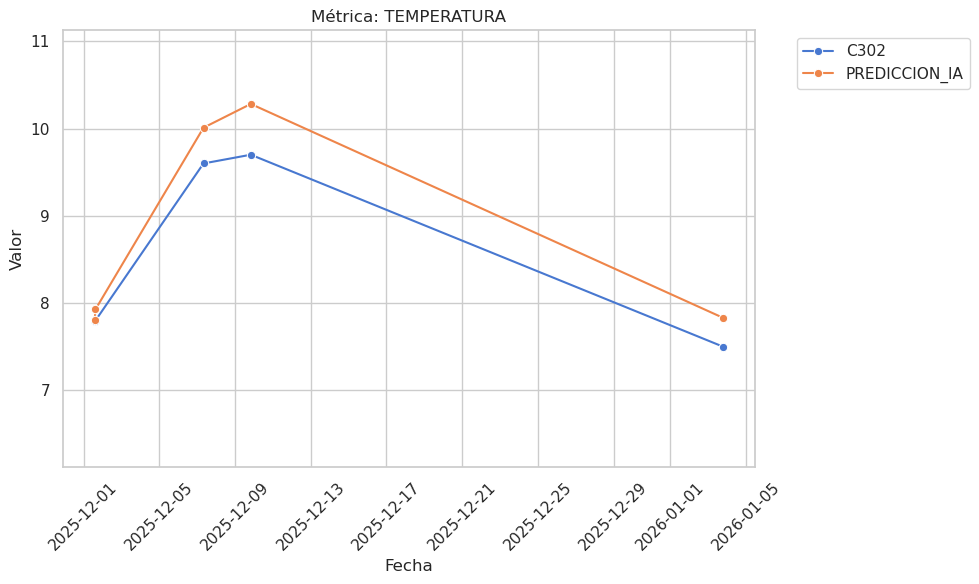

In [313]:
df_pred_viz = pd.DataFrame({
    'timestamp': y_test.index,
    'value': y_pred,
    'sensor_id': f"PREDICCION_IA",
    'metric': METRIC,
    'batch': 'TEST'
})

# Seleccionamos la realidad para comparar
df_real_viz = df_toy[df_toy['timestamp'].isin(y_test.index) & (df_toy['sensor_id'] == TARGET_ID)].copy()

# Unimos
df_final_viz = pd.concat([df_real_viz, df_pred_viz])

pintar_graficas(df_final_viz)

El modelo funciona excepcionalmente bien, gracias a la multicolinealidad de los datos de temperatura del río. Es por ello que se han elegido esas 5 variables iniciales.

Procedemos a determinar el algoritmo de imputación:

La estrategia es: Un modelo por Sensor y por "Contexto" (Batch/Segmento).

Funciona así:

1. Identificamos al paciente (Target): El sensor C302 tiene huecos en la variable TEMPERATURA.

2. Buscamos a los médicos (Vecinos): El grafo nos dice que C312 y C329 son los mejores para curarlo.

3. El Entrenamiento (La Facultad de Medicina):
    - Buscamos en el historial de datos de este batch todos los momentos donde Target, C312 y C329 estuvieron vivos a la vez.
    - Con esos datos (pueden ser 500 horas), entrenamos UN modelo Ridge. Ese modelo aprende: "Cuando C312 sube 1 grado, C302 suele subir 0.98 grados".
4. La Cirugía (Imputación): Usamos ese mismo modelo entrenado para rellenar todos los huecos de C302 en ese periodo, siempre que los vecinos tengan datos.

Esto garantiza coherencia matemática en toda la serie y es computacionalmente muy rápido.

In [314]:
class GraphSpatialImputer:
    def __init__(self, topology_df):
        """
        topology_df: DataFrame con [target_sensor, neighbor_sensor, initial_weight]
                     Se recomienda pasarla ya limpia de duplicados.
        """
        self.topology = topology_df

    def impute_batch(self, df_batch):
        """
        Recibe un DataFrame (idealmente de un periodo continuo o batch).
        Devuelve el mismo DataFrame con los huecos (NaNs) rellenados donde fue posible.
        """
        imputed_parts = []

        # Iteramos por métrica
        for metric in df_batch['metric'].unique():
            df_m = df_batch[df_batch['metric'] == metric].copy()

            # 1. Pivotar (Time x Sensor)
            pivot = df_m.pivot(index='timestamp', columns='sensor_id', values='value')

            # Detectar candidatos
            sensors_with_nans = pivot.columns[pivot.isna().any()].tolist()

            # Si no hay huecos, guardamos y seguimos
            if not sensors_with_nans:
                imputed_parts.append(df_m)
                continue

            print(f"   > Métrica {metric}: Intentando reparar {len(sensors_with_nans)} sensores...")

            for target in sensors_with_nans:
                # 2. Buscar Vecinos en Grafo
                my_topology = self.topology[self.topology['target_sensor'] == target]
                valid_neighbors = [n for n in my_topology['neighbor_sensor'].unique()
                                   if n in pivot.columns]

                if not valid_neighbors:
                    continue

                # 3. Máscaras
                # Entrenamiento: Donde Target y Vecinos tienen datos
                mask_train = pivot[target].notna() & pivot[valid_neighbors].notna().all(axis=1)

                if mask_train.sum() < 12: # Mínimo de datos para aprender
                    continue

                # Relleno: Donde Target es NaN y Vecinos tienen datos
                mask_fill = pivot[target].isna() & pivot[valid_neighbors].notna().all(axis=1)

                if mask_fill.sum() == 0:
                    continue

                # 4. Ridge Regression
                X_train = pivot.loc[mask_train, valid_neighbors]
                y_train = pivot.loc[mask_train, target]

                model = Ridge(alpha=1.0)
                model.fit(X_train, y_train)

                # 5. Imputación
                X_fill = pivot.loc[mask_fill, valid_neighbors]
                predicted_values = model.predict(X_fill)

                pivot.loc[mask_fill, target] = predicted_values

                print(f"      [Reparado] {target}: {mask_fill.sum()} huecos usando {len(valid_neighbors)} vecinos.")

            # 6. Des-Pivotar
            # Usamos future_stack=True para evitar el warning de Pandas 2.1+
            # Esto mantiene los NaNs automáticamente.
            df_filled = pivot.stack(future_stack=True).reset_index()

            # Renombramos la columna generada (que suele ser 0) a 'value'
            df_filled = df_filled.rename(columns={0: 'value'})

            df_filled['metric'] = metric

            # 7. Recuperación de Metadatos
            # Solo traemos columnas que no sean las claves primarias ni el valor
            cols_meta = [c for c in df_m.columns if c not in ['timestamp', 'sensor_id', 'metric', 'value']]

            if cols_meta:
                # Hacemos drop_duplicates para tener un diccionario "timestamp-sensor -> metadatos"
                meta_ref = df_m[['timestamp', 'sensor_id'] + cols_meta].drop_duplicates()

                # Merge Left para pegar los metadatos a la estructura reconstruida
                df_filled = pd.merge(df_filled, meta_ref, on=['timestamp', 'sensor_id'], how='left')

            imputed_parts.append(df_filled)

        if not imputed_parts:
            return df_batch

        return pd.concat(imputed_parts, ignore_index=True)

Limpiamos los duplicados

In [315]:
df_topology_clean = df_topology.sort_values('initial_weight', ascending=False).drop_duplicates(
    subset=['target_sensor', 'neighbor_sensor']
)

In [316]:
imputer = GraphSpatialImputer(df_topology_clean)

In [317]:
print("Ejecutando Imputación Espacial (Ridge + Grafo)...")
df_final_spatial = imputer.impute_batch(df_clean)

# 4. Verificación
nans_antes = df_clean['value'].isna().sum()
nans_despues = df_final_spatial['value'].isna().sum()

print(f"\n--- INFORME DE MISION ---")
print(f"Huecos iniciales: {nans_antes}")
print(f"Huecos finales:   {nans_despues}")
print(f"Datos salvados: {nans_antes - nans_despues}")

Ejecutando Imputación Espacial (Ridge + Grafo)...
   > Métrica AMONIO: Intentando reparar 17 sensores...
      [Reparado] C306: 60 huecos usando 4 vecinos.
      [Reparado] C308: 545 huecos usando 5 vecinos.
      [Reparado] C309: 349 huecos usando 5 vecinos.
      [Reparado] C310: 52 huecos usando 4 vecinos.
      [Reparado] C312: 348 huecos usando 3 vecinos.
      [Reparado] C322: 214 huecos usando 1 vecinos.
      [Reparado] C323: 409 huecos usando 1 vecinos.
      [Reparado] C326: 695 huecos usando 2 vecinos.
      [Reparado] C328: 59 huecos usando 6 vecinos.
      [Reparado] C333: 406 huecos usando 5 vecinos.
   > Métrica CONDUCTIVIDAD: Intentando reparar 29 sensores...
   > Métrica NITRATOS: Intentando reparar 6 sensores...
   > Métrica OXIGENO DISUELTO: Intentando reparar 25 sensores...
      [Reparado] C306: 7 huecos usando 4 vecinos.
      [Reparado] C307: 23 huecos usando 4 vecinos.
      [Reparado] C308: 1156 huecos usando 7 vecinos.
      [Reparado] C309: 372 huecos usando 

In [318]:
df_final_spatial[df_final_spatial['metric']=='TEMPERATURA']

,timestamp,sensor_id,value,metric,unit,batch,trans_value,z_score_abs,segment_id,prev_value,...,delta_abs,own_time_diff,hour,epsilon,severity_rate,is_quiet,block_change,block_id,stagnation_score,max_score_in_block
141014,2025-10-02 14:00:00+00:00,C302,NaN,TEMPERATURA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141015,2025-10-02 14:00:00+00:00,C303,NaN,TEMPERATURA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141016,2025-10-02 14:00:00+00:00,C304,NaN,TEMPERATURA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141017,2025-10-02 14:00:00+00:00,C306,NaN,TEMPERATURA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141018,2025-10-02 14:00:00+00:00,C307,NaN,TEMPERATURA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179469,2026-01-13 19:00:00+00:00,C333,10.3,TEMPERATURA,ºC,batch10,10.3,1.218861,202.0,10.4,...,0.1,0 days 01:00:00,19.0,0.1,1.5,False,False,43215.0,NaN,NaN
179470,2026-01-13 19:00:00+00:00,C342,NaN,TEMPERATURA,ºC,batch10,9.2,0.437195,210.0,9.2,...,0.0,0 days 01:00:00,19.0,0.1,1.0,True,False,44775.0,39.0,39.0
179471,2026-01-13 19:00:00+00:00,C343,11.9,TEMPERATURA,ºC,batch10,11.9,0.394599,218.0,11.9,...,0.0,0 days 01:00:00,19.0,0.1,1.0,True,False,46058.0,12.0,12.0
179472,2026-01-13 19:00:00+00:00,C344,8.2,TEMPERATURA,ºC,batch10,8.2,1.170495,226.0,8.2,...,0.0,0 days 01:00:00,19.0,0.1,1.0,True,False,47858.0,2.0,2.0


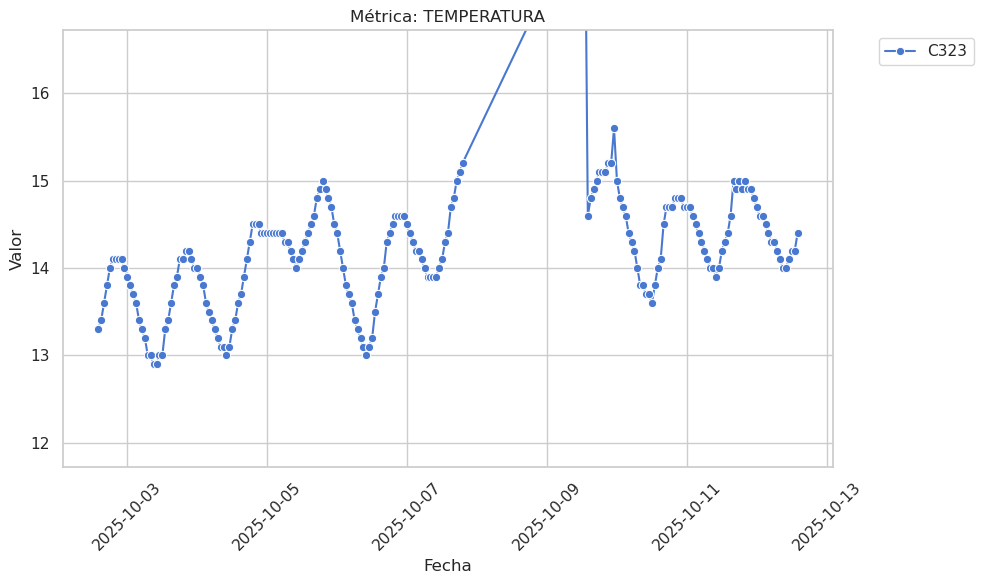

In [319]:
pintar_graficas(df_final_spatial[(df_final_spatial['batch'] == 'batch1') & (df_final_spatial['sensor_id'] == 'C323') & (df_final_spatial['metric'] == 'TEMPERATURA')])

In [320]:
fecha_inicio = '2025-10-08 00:00:00+00:00'
fecha_fin = '2025-10-11 23:59:59+00:00'

df_scored[
    (df_scored['batch'] == 'batch1') &
    (df_scored['sensor_id'] == 'C323') &
    (df_scored['metric'] == 'TEMPERATURA') &
    (df_scored['timestamp'] >= fecha_inicio) &
    (df_scored['timestamp'] <= fecha_fin)
    ][['timestamp','value','sensor_id','metric','stagnation_score']]

,timestamp,value,sensor_id,metric,stagnation_score
152221,2025-10-08 00:00:00+00:00,15.2,C323,TEMPERATURA,5.0
152229,2025-10-08 01:00:00+00:00,15.2,C323,TEMPERATURA,6.0
152237,2025-10-08 02:00:00+00:00,15.2,C323,TEMPERATURA,7.0
152245,2025-10-08 03:00:00+00:00,15.2,C323,TEMPERATURA,8.0
152253,2025-10-08 04:00:00+00:00,15.2,C323,TEMPERATURA,9.0
...,...,...,...,...,...
152949,2025-10-11 19:00:00+00:00,14.9,C323,TEMPERATURA,NaN
152957,2025-10-11 20:00:00+00:00,15.0,C323,TEMPERATURA,NaN
152965,2025-10-11 21:00:00+00:00,14.9,C323,TEMPERATURA,NaN
152973,2025-10-11 22:00:00+00:00,14.9,C323,TEMPERATURA,1.0


Nuestro imputador es extremadamente minucioso a la hora de reconstruir los datos. Pero no podemos dejar tantos huecos en los datos